In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import legume 
legume.set_backend('autograd')
import legume.backend as bd
import numpy as np
import autograd.numpy as npa
from autograd import grad
import time
import matplotlib.pyplot as plt
import optomization

In [237]:
class Cost_local(object):
    """
    Class defining the cost function for the optomization
    """

    def __init__(self, a = 266):
        """
            Holds all the perameters for the cost fucntion

            Args:
                phc_def : this is a function that defines your photonic crystal
                phc_def_inputs : the requred inputs to your phc definition fucntion except
                                 for the variables we alter during optoization. Stored in dictionary
        """
        self.a = a


    def __str__(self):
        """Print the class parameters."""
        out = ""
        for key, value in self.__dict__.items():
            out += f"{key}: {value}\n"
        return(out)
    
    def return_params(self):
        return self.__dict__.copy()

    def cost(self, vars):
        """
        Defines the cost that the optomizer will use
        """
        raise NotImplementedError("cost() needs to be implemented by"
                                  "cost subclasses")
    

class Backscatter(Cost_local):
    """
    Defines the cost function associate with backscattering
    """

    def __init__(self, phidiv = 45, zdiv = 1, lp = 40, sig = 3, **kwargs):
        # Call the master class constructor
        super().__init__(**kwargs)
        self.phidiv = phidiv
        self.lp = lp
        self.sig = sig
        self.zdiv = zdiv


    def hole_borders(self, phc):
        """
        returns the points at the hole borders
        """

        #get relevent information for computation
        shapes = phc.layers[0].shapes
        phis = npa.linspace(0,2*npa.pi,self.phidiv,endpoint=False)
        cphis = bd.cos(phis); sphis = bd.sin(phis)

        #get the array of hole atributes [xpos,ypos,r]
        holeCords = bd.array([[s.x_cent, s.y_cent, s.r] for s in shapes])

        #get the coordinates of the hole borders
        # Compute the initial borders using broadcasting
        x_coords = holeCords[:, 0:1] + holeCords[:, 2:3] * cphis  # Add dimensions for broadcasting
        y_coords = holeCords[:, 1:2] + holeCords[:, 2:3] * sphis

        # Combine x and y coordinates
        initialBorders = bd.stack([x_coords, y_coords], axis=-1)

        # Apply lattice corrections
        xCorrected = bd.where(initialBorders[..., 0] > phc.lattice.a1[0] / 2, 
                             initialBorders[..., 0] - phc.lattice.a1[0], 
                             initialBorders[..., 0])
        yCorrected = bd.where(initialBorders[..., 1] > phc.lattice.a2[0] / 2, 
                             initialBorders[..., 1] - phc.lattice.a2[0], 
                             initialBorders[..., 1])

        # Combine corrected coordinates
        borders = bd.stack([xCorrected, yCorrected], axis=-1)

        return(borders, phis, holeCords[:,2])
    
    def get_xyfield(self,gme,n,xys,k,field='E'):
        """
        returns the field around the holes

        Args:
            gme : the GuidedModeExp object
            n : the mode index
            xys : the coordinates of the points to get the field at, shape (:,:,2)
            z : the z-coordinate of the points to get the field at
            field : the field to get
            components : the components of the field to get
        """

        zSpace = npa.linspace(0,phc.layers[0].d,self.zdiv+1)
        zs = (zSpace[1:]+zSpace[:-1])/2

        FT = bd.stack(
            [
                bd.stack(gme.ft_field_xy(field, k, n, z), axis=0)
                for z in zs
            ],
            axis=0)

        phase = bd.exp(1j*bd.matmul(xys,gme.gvec))

        fis = npa.einsum('ijk,abk->abij',phase,FT)
        
        return(fis)
    
    
    def comp_pdote(self,gme,phc,n,borders,phis,k):
        """
        Computes the E and D dot products for the alpha calculation
        """

        E = self.get_xyfield(gme,n,borders,k)
        D = self.get_xyfield(gme,n,borders,k,field='D')

        Epara = bd.array([-bd.sin(phis)*E[:,0],bd.cos(phis)*E[:,1]])
        Dperp = bd.array([bd.cos(phis)*D[:,0],bd.sin(phis)*D[:,1]])

        p = Epara+(phc.layers[0].eps_b+1)*Dperp/(2*phc.layers[0].eps_b*1)

        pdeR = bd.conj(E[:,0])*bd.conj(p[0])+bd.conj(E[:,1])*bd.conj(p[1])
        pdeRP = E[:,0]*p[0]+E[:,1]*p[1]

        return(pdeR,pdeRP)
    
    def comp_backscatter(self, gme, phc, n, k):
        """
        This runs the calculation of the backscattering divided by the group index
        Given the simulation results
        """
        # get the points around the hole
        borders, phis, holeRad = self.hole_borders(phc)

        # process phis so that they work with the formula
        phisLooped = npa.arctan(npa.tan(phis))

        # get the necessary field information around the holes
        pdeR, pdeRP = self.comp_pdote(gme, phc, n, borders, phis, k)

        # Efficiently compute p dot e cross products using broadcasting
        # pdeR.shape = (Nholes, Nphis), pdeRP.shape = (Nholes, Nphis)
        # Compute meshgrid for each hole at once
        pdeR_ = pdeR[:,:, :, None]  # (zs, Nholes, Nphis, 1)
        pdeRP_ = pdeRP[:, :, None, :]  # (zs, Nholes, 1, Nphis)
        preSumPde = pdeR_ * pdeRP_  # (zs, Nholes, Nphis, Nphis)

        # the real exponential term, using broadcasting
        phiMesh = phisLooped[None, :, None]  # (1, Nphis, 1)
        phiPMesh = phisLooped[None, None, :] # (1, 1, Nphis)
        phiDiff = phiMesh - phiPMesh          # (1, Nphis, Nphis)
        realExp = (npa.abs(phiDiff) * (-holeRad)[:, None, None]) / (self.lp / self.a)

        # the imaginary exponential term, using broadcasting
        x = borders[:, :, 0]  # (Nholes, Nphis)
        xMesh = x[:, :, None]     # (Nholes, Nphis, 1)
        xPMesh = x[:, None, :]    # (Nholes, 1, Nphis)
        kx = 2 * npa.linalg.norm(gme.kpoints[:, 0])
        imagExp = kx * (xMesh - xPMesh)  # (Nholes, Nphis, Nphis)

        # run the integral, including the jacobian determinant
        intigrand = preSumPde * npa.exp(realExp[None,:,:,:] + 1j * imagExp[None,:,:,:])
        weights = (holeRad * npa.pi * 2 / self.phidiv) ** 2  # shape: (Nholes,)
        intigral = npa.sum(intigrand, axis=(2, 3)) * weights

        # calculate the leading coefficients for each of the holes
        cirleCoeffs = ((299792458 * 2 * npa.pi * gme.freqs[0, n]) * (self.sig / self.a) * (phc.layers[0].eps_b - 1) / 2) ** 2

        # compute the final result
        alpha = npa.real(cirleCoeffs * npa.sum(intigral) * (phc.layers[0].d * self.a * 1e-9) ** 2 / self.zdiv)
        
        return(alpha*266*1E-9) #this puts it in units of a^-1
    
    
    def cost(self,gme,phc,n,k=0):
        """
        returns the cost associated with the backscattering
        """
        alpha = npa.log10(self.comp_backscatter(gme,phc,n,k))

        return(alpha)
    

In [238]:
from autograd import value_and_grad
cost2 = Backscatter(zdiv=1)

def objective(vars):
    phc = optomization.W1(vars=vars,Ny=7)
    ks = npa.linspace(npa.pi*.5,npa.pi,25)
    gmeParams = {'verbose':False,'numeig':21,'compute_im':False,'kpoints':npa.array([[float(ks[8])],[0]])}
    gme = legume.GuidedModeExp(phc,2.01)
    gme.run(**gmeParams)
    return cost2.cost(gme,phc,20,0)

vars = optomization.W1Vars(key=0)

t1 = time.time()
for i in range(1):
    value, grad = value_and_grad(objective)(vars)
t2 = time.time()
print(f"Time taken: {(t2-t1)/10} seconds")

Time taken: 0.16330890655517577 seconds


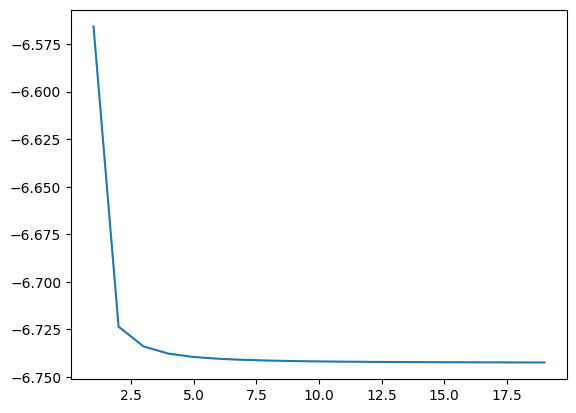

In [239]:
outs = []
for zdiv in np.arange(1,20):
    cost2 = Backscatter(zdiv=zdiv)
    outs.append(cost2.cost(gme,phc,20,0))

plt.plot(np.arange(1,20),outs)
plt.show()

In [3]:
from autograd import value_and_grad
cost = optomization.Backscatter()

def objective(vars):
    phc = optomization.W1(vars=vars,Ny=7)
    ks = npa.linspace(npa.pi*.5,npa.pi,25)
    gmeParams = {'verbose':False,'numeig':21,'compute_im':False,'kpoints':npa.array([[float(ks[8])],[0]])}
    gme = legume.GuidedModeExp(phc,2.01)
    gme.run(**gmeParams)
    return cost.cost(gme,phc,20,0)

vars = optomization.W1Vars(key=0)

t1 = time.time()
for i in range(10):
    value2, grad2 = value_and_grad(objective)(vars)
t2 = time.time()
print(f"Time taken: {(t2-t1)/10} seconds")

Time taken: 1.320504903793335 seconds


In [211]:
print(value2,value)
print((grad2-grad)/grad)

-6.164580705435416 -6.286777499052656
[ 1.66921094  0.01072694 -0.23407449 -0.3199767  -0.37977144 -1.68211992
  0.21719228 -1.54903527  0.08321739  0.01851221  0.12945196  0.17782102
  0.79782347  0.18647778  0.09616728 -0.10368845  0.02845203  0.08828954]


In [37]:
np.real(out2['x'])-np.real(out[:,:,0])

array([[-1.59594560e-16, -6.93889390e-17, -4.30211422e-16,
         4.85722573e-17, -2.35922393e-16, -3.46944695e-16,
         3.88578059e-16, -3.19189120e-16,  5.55111512e-17,
        -4.44089210e-16,  0.00000000e+00,  2.08166817e-16,
         1.17961196e-16, -4.16333634e-17,  0.00000000e+00,
         2.63677968e-16, -4.44089210e-16,  5.55111512e-17,
        -1.11022302e-16, -1.52655666e-16, -1.94289029e-16,
        -2.77555756e-17, -3.46944695e-17,  2.77555756e-17,
         1.38777878e-16, -4.37150316e-16,  8.04911693e-16,
         3.05311332e-16, -9.71445147e-17,  9.71445147e-17,
         1.66533454e-16,  1.66533454e-16,  9.71445147e-17,
        -2.63677968e-16, -2.13370988e-16, -6.93889390e-18,
         4.16333634e-17,  3.19189120e-16,  4.02455846e-16,
         4.02455846e-16,  3.74700271e-16, -4.16333634e-16,
         3.46944695e-17, -1.45716772e-16,  1.87350135e-16],
       [-1.80411242e-16, -5.55111512e-17, -1.52655666e-16,
         9.71445147e-17,  2.22044605e-16, -2.77555756e-

In [204]:
zSpace = npa.linspace(0,phc.layers[0].d,3)
zs = (zSpace[1:]+zSpace[:-1])/2
print(zs)

[0.15977444 0.47932331]


In [201]:
print(phc.layers[0].d)

0.6390977443609023
